In [1]:
import torch
import kornia
import cv2
import matplotlib.pyplot as plt 
import numpy as np

from kornia.morphology import dilation, opening, closing
from kornia.utils import tensor_to_image, draw_rectangle
from kornia.contrib import connected_components
from kornia.geometry.transform import resize


In [2]:
def get_side(tensor, general_thresh=160, sidelength_threshold=50):

    assert tensor.ndim == 2
    
    # compute thresholded image (only white parts)
    thresholded = tensor[20:] > general_thresh

    # dilate to keep them together
    dilated = dilation(thresholded[None, None, :, :], torch.ones(5,20, device='cuda:0'), border_type='constant')
    connected_comp = connected_components(dilated, num_iterations=200)
    
    # keep connected components with large enough horizontal length
    labels = connected_comp.unique(sorted=True)[1:]
    kept_labels = []

    for lab in labels:
        _,_,x,y = torch.nonzero(torch.where(connected_comp == lab, 1, 0), as_tuple=True)

        if torch.max(y) - torch.min(y) > sidelength_threshold:
            kept_labels.append(lab)
            
    side = (connected_comp[..., None] == torch.tensor(kept_labels, device='cuda:0')).any(-1).double()
    
    return side

In [28]:
def tensor_to_features(tensor, side_thresh=200, mid_thresh=160, sidelength_threshold=50):

    assert tensor.ndim == 2
    
    # compute thresholded image (only white parts)
    side_thresholded = tensor[20:] > side_thresh
    mid_thresholded  = (tensor[20:] > mid_thresh)[None, None, :, :]
    
    # dilate to keep them together
    dilated = dilation(side_thresholded[None, None, :, :], torch.ones(5,20, device='cuda:0'), border_type='constant')
    connected_comp = connected_components(dilated, num_iterations=200)
    
    # keep connected components with large enough horizontal length
    labels = connected_comp.unique(sorted=True)[1:]
    kept_labels = []

    for lab in labels:
        _,_,x,y = torch.nonzero(torch.where(connected_comp == lab, 1, 0), as_tuple=True)

        if torch.max(y) - torch.min(y) > sidelength_threshold:
            kept_labels.append(lab)
            
    side = (connected_comp[..., None] == torch.tensor(kept_labels, device='cuda:0')).any(-1).double()

    # dilate side line to remove it from rest of image
    dilated_side = dilation(side, torch.ones(10,7,device='cuda:0'), border_type='constant')
    removed_upper = ((mid_thresholded.double() - dilated_side) > 0).double()
    
    # open to remove noise
    open_mid = opening(removed_upper, torch.ones(6,6, device='cuda:0'))
    
    # close to join midlines together
    closed_midline = closing(open_mid, torch.ones(40,40, device='cuda:0'), border_type='geodesic')
    closed_midline = draw_rectangle(closed_midline, torch.tensor([[[0, 0, 160, 120]]], device='cuda:0'), fill=torch.zeros(1, device='cuda:0'))
    
    # reassemble together in a single image
    resized_mid  = (resize(closed_midline,(16,16), interpolation='area') > 0.2).double()*0.5
    resized_side = (resize(side,(16,16), interpolation='area') > 0.2).double()
    
    return resized_mid + resized_side

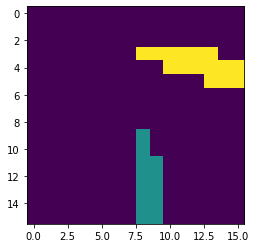

In [30]:
img = cv2.imread('data/left_0000.png', cv2.IMREAD_GRAYSCALE)
tensor = torch.tensor(img, device='cuda:0')
plt.imshow(tensor_to_image(tensor_to_features(tensor, side_thresh=200, mid_thresh=160)))

In [6]:
tensor_to_features(tensor, side_thresh=200, mid_thresh=160).unique()

tensor([0, 1], device='cuda:0', dtype=torch.int32)